In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model

# reflect the tables
Base = automap_base()
Base.prepare(engine, reflect=True)


In [8]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [23]:
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [24]:
inspector = inspect(engine)
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [132]:
# Find the most recent date in the data set.
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).limit(1).all()[0][0]
most_recent_date


'2017-08-23'

In [133]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
import datetime as dt
from dateutil import parser
most_recent_date = parser.parse(most_recent_date)

# Calculate the date one year from the last date in data set.
one_year_ago = most_recent_date - dt.timedelta(days=365)
one_year_ago

# Perform a query to retrieve the data and precipitation scores
prcp_scores = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= one_year_ago.strftime('%Y-%m-%d'), Measurement.date <= most_recent_date.strftime('%Y-%m-%d')).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(prcp_scores, columns=['Date', 'Precipitation'])
df['Precipitation'].fillna(0, inplace=True)
df['Date'] = pd.to_datetime(df['Date'], format="%Y-%m-%d")
df.set_index('Date', inplace=True)

# Sort the dataframe by date
df.sort_index()

#pd.set_option("display.max_rows", None)
#pd.reset_option("display.max_rows")

df

,Precipitation
Date,
2016-08-23,0.00
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00
...,...
2017-08-19,0.09
2017-08-20,0.00
2017-08-21,0.56


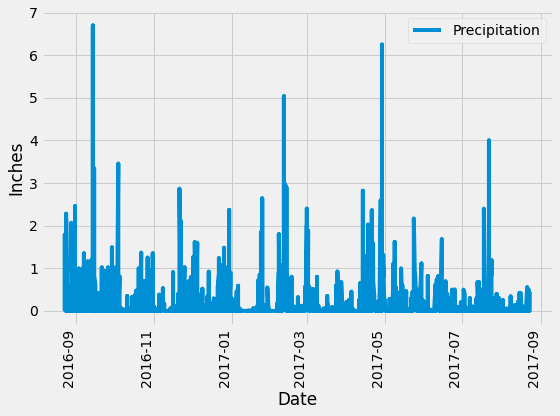

In [143]:
# Use Pandas Plotting with Matplotlib to plot the data
ax = df.plot(rot = 90, figsize = (8,6))
plt.ylabel('Inches')
plt.tight_layout()
plt.show()



In [137]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df['Precipitation'].describe()


count    2230.000000
mean        0.160664
std         0.442067
min         0.000000
25%         0.000000
50%         0.010000
75%         0.110000
max         6.700000
Name: Precipitation, dtype: float64

In [141]:
# ** Decided to add in calculating the total precipitation of each station **
station_totals = session.query(Measurement.station, func.sum(Measurement.prcp)).\
    group_by(Measurement.station).\
    order_by(func.sum(Measurement.prcp).desc()).all()

station_totals_df = pd.DataFrame(station_totals, columns=['Station', 'Total_Precipitation'])
station_totals_df

,Station,Total_Precipitation
0,USC00516128,1068.09
1,USC00519281,588.64
2,USC00513117,382.62
3,USC00519523,295.68
4,USC00514830,234.49
5,USC00519397,131.62
6,USC00511918,92.68
7,USC00518838,70.87
8,USC00517948,43.44


# Close session

In [142]:
# Close Session
session.close()